# RSNA-MICCAI Brain Tumor Radiogenomic Classification
Predict the status of a genetic biomarker important for brain cancer treatment 

 Zhara Ali

## Imports

In [19]:
# basics code from https://www.kaggle.com/abdelrhmanhosny/brain-tumor-classification/notebook
import numpy as np # linear algebra
print('numpy: {}'.format(np.__version__))
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('pandas: {}'.format(pd.__version__))
import matplotlib.pyplot as plt
import os
from os.path import join
import sys
from sklearn.model_selection import train_test_split
# pytorch model

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.utils import data as torch_data


# pyTorch Lightning

import pytorch_lightning as pl
from torchmetrics import Accuracy

# image processing

from skimage.io import imread
from scipy.ndimage import zoom # image resizing 3D
from skimage.transform import resize
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import tensorflow as tf
print('tensorflow: {}'.format(tf.__version__))

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


from tensorflow.keras.callbacks import TensorBoard

import seaborn as sns
import re
import zipfile
import cv2
import pickle

numpy: 1.21.2
pandas: 1.3.4
tensorflow: 2.6.0


## Data distribution

As we can see on the graphs, the data are well balanced (no huge dominance for one of the classes)

<AxesSubplot:xlabel='value', ylabel='count'>

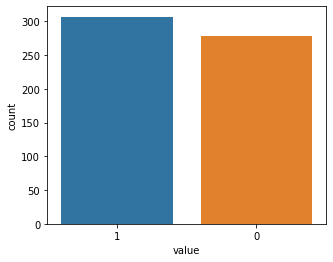

In [2]:
#open the training labels data 
df = pd.read_csv("E:\\Proj_data/train_labels.csv", header=0, names=['id','value'], dtype=object)
#exclude_cases = ["00109", "00123", "00709"] #according to description
#df = df[~df.id.isin(exclude_cases)]
df = df.sort_values('id')
df.head()

# values distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="value")

In [3]:
#create output dataset folders
os.makedirs('./train', exist_ok = True)
print('Train folder created')

os.makedirs('./validation', exist_ok = True)
print('Validation folder created')

Train folder created
Validation folder created


## First try at creating the dataset (fail) 

In [10]:
 """"import zipfile
from zipfile import Path

#extraire une seule slice du milieu pour commencer cad une seule image des dossiers   
filepath = 'E:\\Proj_data/train.zip'
with zipfile.ZipFile(filepath, 'r') as zfile:
    #zfile.printdir()
    data = zfile.open('00009/T1wCE/Image-150.dcm')  #test
    data2 = zfile.open('00002/T1wCE/Image-50.dcm')  #test
    
    data_array = []
    length = 10
    
    n_list = []
    
    def get_list(p3) :  #get a list with the number of images inside our file
        string1 = p3[1]
        n = int(re.search(r'\d+', string1).group()) #gives the number part of the name file (ex: gets 20 from Image-20)
        n_list.append(n)
        return n_list

    def get_path(n_list): #creates an image path for the middle slice of our file 
        n_max=len(n_list) 
        print('len=', n_max)
        n2 = int(n_max/2)
        endpath = f'Image-{n2}.dcm'
        print('endpath=', endpath)
        return endpath
    
    for file in zfile.namelist() :  #pb: on prend image par image donc boucle counter ne fonctionne pas correctement  
        p1 = os.path.split(file) 
        p2 = os.path.split(p1[0])
        p3 = os.path.split(p1[1]) 
        m=0
        type1 = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
        
        for counter in range(1): #get the images from the 3 first FLAIR files, works if we put range(1) meaning only for the file 0000 for now  
            try :
                dossier = f'0{str(counter).zfill(4)}' #file 00001 doesnt exist (same for other ones)
                type_im =type1[m]
                if (p2[0]==dossier and p2[1]==type_im) :
                    n_list = get_list(p3)
            except :  #(p2[0]!=dossier) if the file doesnt exist, we go to the next one --> this doesnt work, we dont get an error message if the file doesnt exist  
                counter+=1
    
    endpath=get_path(n_list)
    
    for file in zfile.namelist() : 
        p1 = os.path.split(file)
        p2 = os.path.split(p1[0])
        p3 = os.path.split(p1[1])
        if (p3[1]==endpath and p2[0]==dossier and p2[1]==type_im) :   #if we have the right image, we add it to our data list
            data_array.append(file)
            print('okkkk')
  
    for i in range(10) : #display 10 images from our data list, we get list index out of range which is normal since the list is empty 
        print(data_array)
        data3 = zfile.open(data_array[i])
        ds3 = dicom.dcmread(data3)
        plt.imshow(ds3.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
        plt.show()
        
#ds = dicom.dcmread(data)
#ds2 = dicom.dcmread(data2)

  
#plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
#plt.show()
  
#plt.imshow(ds2.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
#plt.show()
""""
""""#function to resize the images 
import cv2 as cv
def resize_im(path, size = (128,128)):
    image = cv.imread(path)
    resized_image = cv.resize(image, size)
    #print(resized_image.shape)
    return resized_image

for f in os.listdir('./train') :
    path = './train/' + f
    #print(path)
    #im=imread(path)
    #print(im.shape)
    try :
        resize_im(path)  
    except :
        continue""""

SyntaxError: EOL while scanning string literal (Temp/ipykernel_15620/2153203526.py, line 72)

## Creating the dataset with 'FLAIR' type images

348642 total files
74248 FLAIR files
585 middle slices
Display first image:
00000/FLAIR/Image-200.dcm


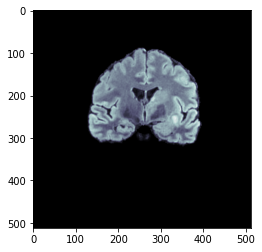

error, file doesnt exist -> skip
00818/FLAIR/Image-14.dcm
the end


KeyboardInterrupt: 

In [12]:
filepath =  'E:\\Proj_data/train.zip'
with zipfile.ZipFile(filepath, 'r') as zfile:
    # Liste de tous les fichiers dans le ZIP
    all_files = zfile.namelist()
    print(len(all_files),"total files")
    
    # Filtrer pour ne garder que les chemins qui contiennent "FLAIR"
    FLAIR_files = [f for f in all_files if 'FLAIR' in f] #creer liste avec tout les fichiers flair 
    print(len(FLAIR_files),"FLAIR files")
    
    # Construire dict avec les IDs d'image existant & tous les slices pour chaque image
    FLAIR_per_image = {}
    for f in FLAIR_files:
        image_id = f.split('/')[0] #nom des dossier ex. 00000
        slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) #numero de l'image ex Image-50 --> 50
        if image_id not in FLAIR_per_image: #ajouter l'image dans le dossier 
            FLAIR_per_image[image_id] = []
        FLAIR_per_image[image_id].append(slice_id)
    
    # Trouver le slice du milieu pour chaque image
    FLAIR_middle_slices = []
    for image_id in FLAIR_per_image:
        FLAIR_per_image[image_id].sort()
        middle_slice = FLAIR_per_image[image_id][len(FLAIR_per_image[image_id])//2]
        FLAIR_middle_slices.append('%s/FLAIR/Image-%d.dcm'%(image_id, middle_slice-1))
    
    print(len(FLAIR_middle_slices),"middle slices") 
    
    # Afficher le 1er
    print("Display first image:")
    for f in FLAIR_middle_slices:
        print(f)
        data = zfile.open(f)
        ds = dicom.dcmread(data)
        plt.figure()
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
        plt.show()
        break
        
    for i in range(len(FLAIR_middle_slices)) :
        if (FLAIR_middle_slices==[]) :
            print('Empty list')
            break
        else :
            for f in FLAIR_middle_slices:  #reussir a sortir chaque filepath de la list 
                try :
                    data = zfile.open(f)
                except KeyError :
                    print("error, file doesnt exist -> skip")
                    print(f)
                    continue 
                    
                #print(data)
                ds = dicom.dcmread(data)
                image_id = f.split('/')[0] #nom des dossier ex. 00000
                slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) 
                image_path = './train/' + str(image_id) + '_FLAIR_Image-' + str(slice_id) + '.dcm'   #'./train/00071_T1wCE_Image-51.dcm' -> fonctionne avec ca  #pas avec l'autre pcq dossier 000000 n'E pas dans le file train
                #print(image_path)
                #print(ds.pixel_array)
                #print(type(ds.pixel_array))
 
                image_path = image_path.replace('.dcm', '.png') #convertir type d'image de dcm en png
                #print(image_path)
                
                
                plt.imsave(image_path ,ds.pixel_array) 
                
                if (image_id==str(1010).zfill(5)):
                    print("the end")
                    break
    print("done")
    


In [3]:
#load the dataset created 
path = './train'
for im in os.listdir(path) :
    im_array = cv2.imread(os.path.join(path,im))
    #plt.imshow(im_array,cmap=plt.cm.bone)
    #plt.show()

In [74]:
print(im_array.shape)


(256, 192, 3)


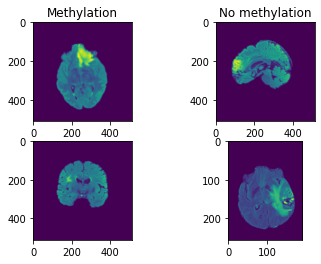

In [6]:
#display some images
im1 = imread('./train/00006_FLAIR_Image-449.png')
im2 = imread('./train/00009_FLAIR_Image-120.png')
im3 = imread('./train/00066_FLAIR_Image-184.png')
im4 = imread('./train/00172_FLAIR_Image-30.png')

plt.subplot(221)
plt.imshow(im1, cmap=plt.cm.bone)  # set the color map to bone
plt.title('Methylation')

plt.subplot(222)
plt.imshow(im2, cmap=plt.cm.bone)  # set the color map to bone
plt.title('No methylation')

plt.subplot(223)
plt.imshow(im3, cmap=plt.cm.bone)  # set the color map to bone

plt.subplot(224)
plt.imshow(im4, cmap=plt.cm.bone)  # set the color map to bone


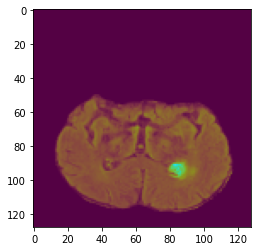

In [78]:
#resizing the data
IM_SIZE = 128
new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
plt.imshow(new_array)
plt.show()

In [8]:
import csv 
image_labels = {}
with open('E:\\Proj_data/train_labels.csv', mode='r') as fp:
    reader = csv.reader(fp)
    header = True
    for label,value in reader:
        if header:
            header = False
            continue # skip first line
        image_labels[label] = value
print(image_labels)
#image_labels['00002'] devrait te donner '1', etc.

{'00000': '1', '00002': '1', '00003': '0', '00005': '1', '00006': '1', '00008': '1', '00009': '0', '00011': '1', '00012': '1', '00014': '1', '00017': '0', '00018': '0', '00019': '0', '00020': '1', '00021': '0', '00022': '0', '00024': '0', '00025': '1', '00026': '1', '00028': '1', '00030': '0', '00031': '1', '00032': '0', '00033': '1', '00035': '1', '00036': '0', '00043': '1', '00044': '0', '00045': '0', '00046': '1', '00048': '1', '00049': '0', '00052': '1', '00053': '0', '00054': '1', '00056': '1', '00058': '1', '00059': '1', '00060': '1', '00061': '0', '00062': '1', '00063': '1', '00064': '0', '00066': '1', '00068': '1', '00070': '1', '00071': '1', '00072': '0', '00074': '1', '00077': '1', '00078': '1', '00081': '0', '00084': '0', '00085': '1', '00087': '1', '00088': '0', '00089': '1', '00090': '0', '00094': '1', '00095': '0', '00096': '1', '00097': '0', '00098': '1', '00099': '0', '00100': '1', '00102': '0', '00104': '0', '00105': '1', '00106': '1', '00107': '1', '00108': '0', '0010

In [26]:
#creating the training dataset 
#original code from https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

train_data = []

def create_train_ds():
    #length = len(image_labels)
    #print(length)
    for im in os.listdir(path) :            
        k = im.split('_')[0]
        try :
            im_array = cv2.imread(os.path.join(path,im))
            new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
            print(k)
            print(image_labels[k])
            train_data.append([new_array,image_labels[k]])
        except : 
            print('error')
            print(im)
            continue


        
create_train_ds()
#print(new_array)
print(len(new_array))

00000
1
00002
1
00003
0
00005
1
00006
1
00008
1
00009
0
00011
1
00012
1
00014
1
00017
0
00018
0
00019
0
00020
1
00021
0
00022
0
00024
0
00025
1
00026
1
00028
1
00030
0
00031
1
00032
0
00033
1
00035
1
00036
0
00043
1
00044
0
00045
0
00046
1
00048
1
00049
0
00052
1
00053
0
00054
1
00056
1
00058
1
00059
1
00060
1
00061
0
00062
1
00063
1
00064
0
00066
1
00068
1
00070
1
00071
1
00072
0
00074
1
00077
1
00078
1
00081
0
00084
0
00085
1
00087
1
00088
0
00089
1
00090
0
00094
1
00095
0
00096
1
00097
0
00098
1
00099
0
00100
1
00102
0
00104
0
00105
1
00106
1
00107
1
00108
0
00109
1
00110
0
00111
0
00112
0
00113
0
00116
0
00117
1
00120
1
00121
0
00122
0
00123
0
00124
0
00128
1
00130
0
00132
0
00133
0
00134
1
00136
1
00137
0
00138
1
00139
1
00140
1
00142
0
00143
1
00144
1
00146
1
00147
0
00148
0
00149
0
00150
0
00151
0
00154
0
00155
1
00156
1
00157
0
00158
0
00159
1
00160
1
00162
0
00165
0
00166
1
00167
0
00169
0
00170
0
00171
1
00172
0
00176
0
00177
1
00178
1
00183
0
00184
0
00185
1
00186
1
00187
1


In [27]:
print(len(train_data))

584


In [28]:
train_x = [] #feature set
train_y = [] #labels

for features,label in train_data:
    train_x.append(features)
    train_y.append(label)

print(train_x[0].reshape(-3, IM_SIZE, IM_SIZE, 3))  #3 for RGB, 1 for grayscale 
#print(label['value'])
train_x = np.array(train_x).reshape(-3, IM_SIZE, IM_SIZE, 3)

[[[[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  ...

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]]]


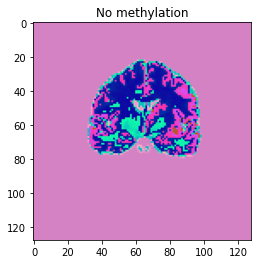

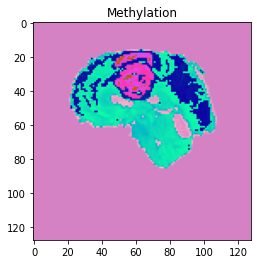

In [79]:
#comparison between tumor and no tumor : no meth = 0, meth = 1
no_meth = train_x[0]
plt.figure()
plt.title("No methylation")
plt.imshow((no_meth*255).astype('uint8'))
plt.show()


meth = train_x[2]
plt.figure()
plt.title("Methylation")
plt.imshow((meth*255).astype('uint8'))
plt.show()

In [29]:
#save the data
#code from https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

pickle_out = open("train_x.pickle","wb")
pickle.dump(train_x, pickle_out)
pickle_out.close()

pickle_out = open("train_y.pickle","wb")
pickle.dump(train_y, pickle_out)
pickle_out.close()

In [17]:
print('GPUs available: ', len(tf.config.list_physical_devices('GPU')))

GPUs available:  0


In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7714396320745011146
]


## (Preparing test dataset)
Following the same steps as with the train dataset => Not usable because its not labelled 

51473 total files
10816 FLAIR files
87 middle slices
Display first image:
00001/FLAIR/Image-104.dcm


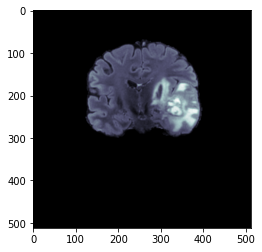

the end


KeyboardInterrupt: 

In [29]:
filepath =  'E:\\Proj_data/test.zip'
with zipfile.ZipFile(filepath, 'r') as zfile:
    # Liste de tous les fichiers dans le ZIP
    all_files = zfile.namelist()
    print(len(all_files),"total files")
    
    # Filtrer pour ne garder que les chemins qui contiennent "FLAIR"
    FLAIR_files = [f for f in all_files if 'FLAIR' in f] #creer liste avec tout les fichiers flair 
    print(len(FLAIR_files),"FLAIR files")
    
    # Construire dict avec les IDs d'image existant & tous les slices pour chaque image
    FLAIR_per_image = {}
    for f in FLAIR_files:
        image_id = f.split('/')[0] #nom des dossier ex. 00000
        slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) #numero de l'image ex Image-50 --> 50
        if image_id not in FLAIR_per_image: #ajouter l'image dans le dossier 
            FLAIR_per_image[image_id] = []
        FLAIR_per_image[image_id].append(slice_id)
    
    # Trouver le slice du milieu pour chaque image
    FLAIR_middle_slices = []
    for image_id in FLAIR_per_image:
        FLAIR_per_image[image_id].sort()
        middle_slice = FLAIR_per_image[image_id][len(FLAIR_per_image[image_id])//2]
        FLAIR_middle_slices.append('%s/FLAIR/Image-%d.dcm'%(image_id, middle_slice-1))
    
    print(len(FLAIR_middle_slices),"middle slices") 
    
    # Afficher le 1er
    print("Display first image:")
    for f in FLAIR_middle_slices:
        print(f)
        data = zfile.open(f)
        ds = dicom.dcmread(data)
        plt.figure()
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
        plt.show()
        break
        
    for i in range(len(FLAIR_middle_slices)) :
        if (FLAIR_middle_slices==[]) :
            print('Empty list')
            break
        else :
            for f in FLAIR_middle_slices:  #reussir a sortir chaque filepath de la list 
                try :
                    data = zfile.open(f)
                except KeyError :
                    print("error, file doesnt exist -> skip")
                    print(f)
                    continue 
                    
                #print(data)
                ds = dicom.dcmread(data)
                image_id = f.split('/')[0] #nom des dossier ex. 00000
                slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) 
                image_path = './test/' + str(image_id) + '_FLAIR_Image-' + str(slice_id) + '.dcm'   #'./train/00071_T1wCE_Image-51.dcm' -> fonctionne avec ca  #pas avec l'autre pcq dossier 000000 n'E pas dans le file train
                #print(image_path)
                #print(ds.pixel_array)
                #print(type(ds.pixel_array))
 
                image_path = image_path.replace('.dcm', '.png') #convertir type d'image de dcm en png
                #print(image_path)
                
                
                plt.imsave(image_path ,ds.pixel_array) 
                
                if (image_id==str(1006).zfill(5)):
                    print("the end")
                    break
    print("done")
    


In [30]:
#load the dataset created 
path = './test'
for im in os.listdir(path) :
    im_array = cv2.imread(os.path.join(path,im))
    #plt.imshow(im_array,cmap=plt.cm.bone)
    #plt.show()

In [31]:
print(im_array.shape)

(256, 256, 3)


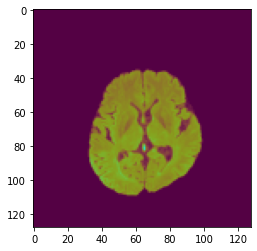

In [32]:
#resizing the data
IM_SIZE = 128
new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
plt.imshow(new_array)
plt.show()

In [33]:
test_data = []

def create_test_ds():
    for im in os.listdir(path) :            
        k = im.split('_')[0]
        try :
            im_array = cv2.imread(os.path.join(path,im))
            new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
            test_data.append([new_array])
        except : 
            print('error')
            print(im)
            continue

            
  
create_test_ds()

print(len(new_array))

error
00208_FLAIR_Image-30.png
128


In [36]:
test_x = [] #images

for images in test_data:
    test_x.append(images)

#print(test_x[0].reshape(-3, IM_SIZE, IM_SIZE, 3))  #3 for RGB, 1 for grayscale 
test_x = np.array(test_x).reshape(-3, IM_SIZE, IM_SIZE, 3)

In [37]:
#save the data
#code from https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

pickle_out = open("test_x.pickle","wb")
pickle.dump(test_x, pickle_out)
pickle_out.close()


In [38]:
pickle_in = open("test_x.pickle","rb")
test_x = pickle.load(pickle_in)

print(len(test_x))
print(test_x)

86
[[[[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  ...

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]]


 [[[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  ...

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
  

# First model test : CNN

In [2]:
#Data prep, loading the dataset 

import datetime

NAME = "sequential_mdl_test" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

pickle_in = open("train_x.pickle","rb")
train_x = pickle.load(pickle_in)

pickle_in = open("train_y.pickle","rb")
train_y = pickle.load(pickle_in)

train_x = train_x/255.0-0.5
print(len(train_x))

train_y_1D = train_y
train_y = np.asarray(train_y).astype('float32').reshape((-1,1))

train_y = tf.keras.utils.to_categorical(train_y)
print(len(train_y))

print(train_y)
print(train_y_1D)

584
584
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
['1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '

In [3]:
train_xx, test_x, train_yy_1D, test_y_1D = train_test_split(train_x, train_y_1D, test_size=0.1)

#keeping 1D array of test label to use it for the confusion matrix 
train_yy = np.asarray(train_yy_1D).astype('float32').reshape((-1,1))
train_yy = tf.keras.utils.to_categorical(train_yy)
test_y = np.asarray(test_y_1D).astype('float32').reshape((-1,1))
test_y = tf.keras.utils.to_categorical(test_y)
print(test_y_1D)
print(test_y)

train_X, val_X, train_Y, val_Y = train_test_split(train_xx, train_yy, test_size=0.15) #split un test dataset de ici aussi, par defaut c'est shuffled 

['1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1']
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [4]:
from keras import backend as K
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.learning_rate.assign(0.0001)
print(optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [5]:
#Model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=train_x.shape[1:]))  #64param
model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3))) #rajouter des conv pour pas diminuer la taille du réseau trop rapidement 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(32)) #Fully connected layer, needs 1D ds
model.add(Dropout(0.2)) #freeze 20% des poids
model.add(Activation('relu'))

model.add(Dense(2)) #mieux de faire sortir 2 classes 
model.add(Activation('softmax')) #activation=fct non lineaire, pb sigmoid=grad tres faible pr petites val -> mieux d'utiliser relu (grad 0 ou 1, pas de vanishing grad)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
activation (Activation)      (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 16)        4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 16)        2

In [6]:
model.fit(train_X ,train_Y, batch_size=6, epochs=30, validation_data = (val_X, val_Y) ,callbacks=[tensorboard])

Epoch 1/30
75/75 [==============================] - 12s 144ms/step - loss: 0.6927 - categorical_accuracy: 0.5336 - val_loss: 0.6967 - val_categorical_accuracy: 0.4937
Epoch 2/30
75/75 [==============================] - 10s 133ms/step - loss: 0.6826 - categorical_accuracy: 0.5448 - val_loss: 0.6880 - val_categorical_accuracy: 0.4937
Epoch 3/30
75/75 [==============================] - 9s 119ms/step - loss: 0.6815 - categorical_accuracy: 0.5740 - val_loss: 0.6885 - val_categorical_accuracy: 0.5063
Epoch 4/30
75/75 [==============================] - 10s 135ms/step - loss: 0.6729 - categorical_accuracy: 0.6054 - val_loss: 0.6894 - val_categorical_accuracy: 0.5823
Epoch 5/30
75/75 [==============================] - 10s 137ms/step - loss: 0.6703 - categorical_accuracy: 0.5852 - val_loss: 0.6854 - val_categorical_accuracy: 0.5823
Epoch 6/30
75/75 [==============================] - 9s 116ms/step - loss: 0.6623 - categorical_accuracy: 0.6211 - val_loss: 0.7117 - val_categorical_accuracy: 0.5063


In [8]:
model.evaluate(test_x,test_y, batch_size=6)

10/10 [==============================] - 0s 22ms/step - loss: 1.6185 - categorical_accuracy: 0.5085


[1.6184695959091187, 0.508474588394165]

## Visualization

In [9]:
import visualkeras
#source : https://github.com/paulgavrikov/visualkeras

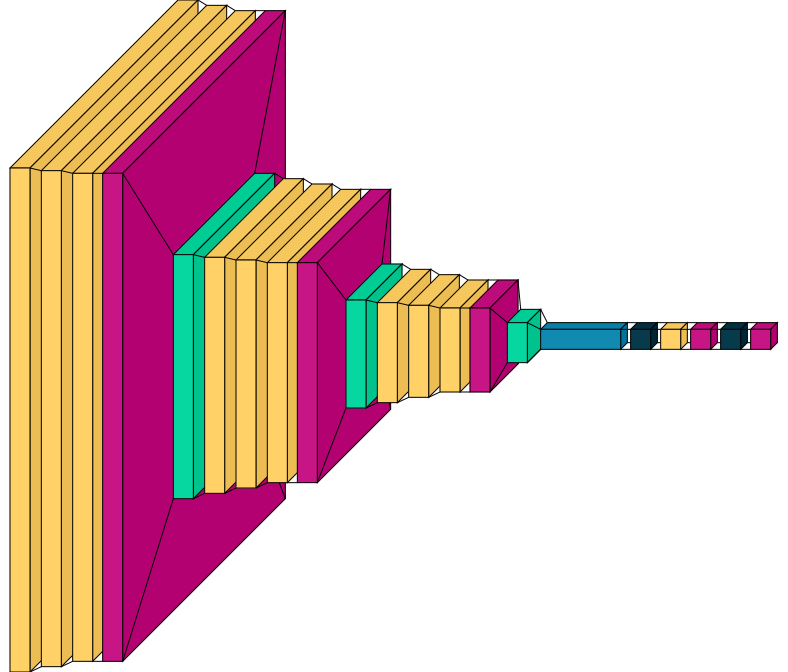

In [10]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict
import visualkeras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'lightpink'
color_map[Activation]['fill'] = 'mediumvioletred'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'mediumorchid'
color_map[Dense]['fill'] = 'palevioletred'
color_map[Flatten]['fill'] = 'plum'

visualkeras.layered_view(model, color_map=color_map)

## Confusion matrix
Can't be done with the test dataset since its not labelled, tried with the train dataset even if useless

In [11]:
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,classification_report
import itertools
from skimage.io import imread,imsave,imshow

In [12]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='RdPu'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    save = imsave('results/confusionmatrix.png',cm)
#https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example


In [13]:
#use the test dataset
Y_pred = model.predict(test_x)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(test_y_1D, y_pred.astype(str), target_names=target_names))
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

(59,)
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.39      0.45        31
           1       0.49      0.64      0.55        28

    accuracy                           0.51        59
   macro avg       0.52      0.51      0.50        59
weighted avg       0.52      0.51      0.50        59



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Normalized confusion matrix


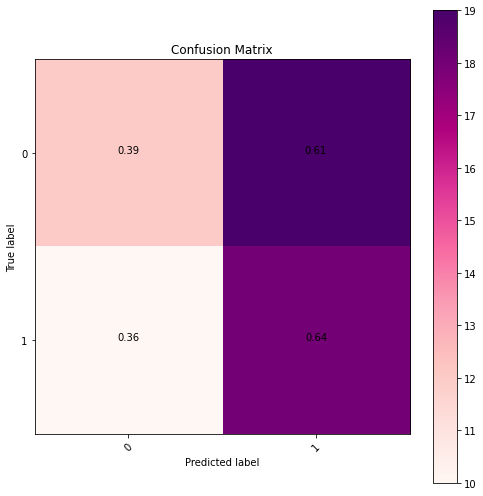

In [14]:
#Confusion Matrix 
cm = confusion_matrix(test_y_1D,y_pred.astype(str))
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

## (Testing the model with the test dataset)
Non labelled images -> can't verify the accuracy

In [39]:
pickle_in = open("test_x.pickle","rb")
test_x = pickle.load(pickle_in)

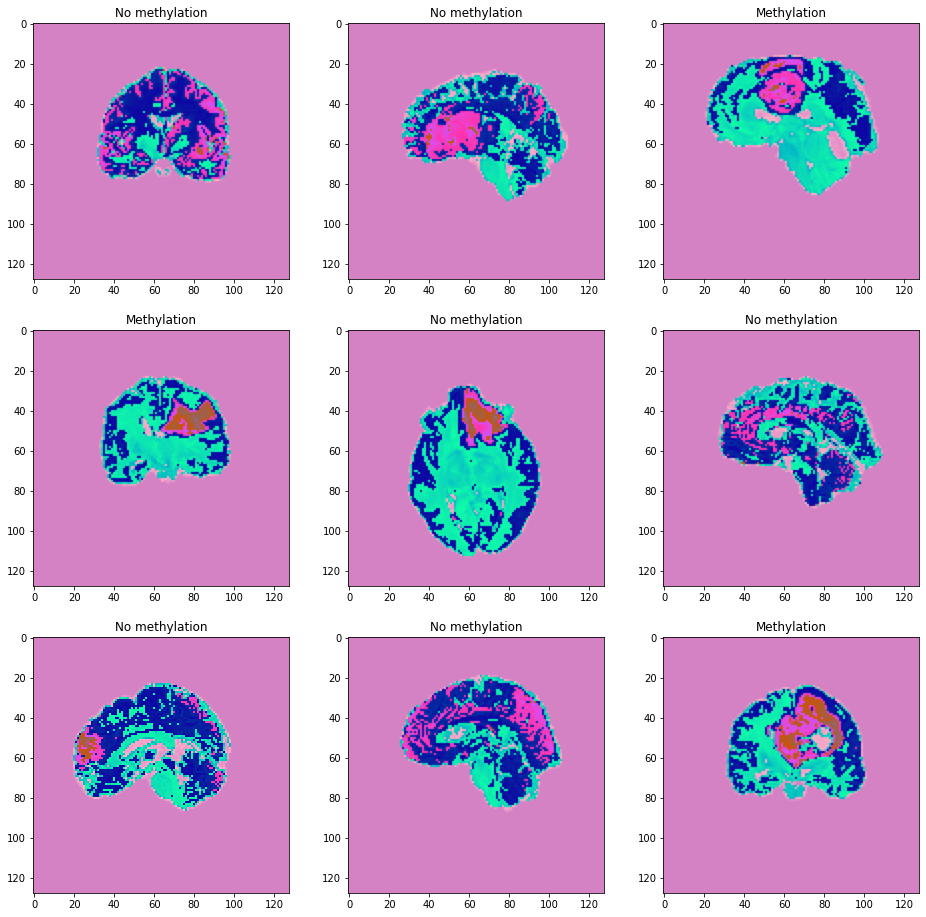

In [78]:
CATEGORIES = ["No methylation","Methylation"]  #no meth = 0, meth = 1 :  In patients who received radiotherapy alone following resection, methylation of the MGMT promoter correlated with an improved response to radiotherapy. Unmethylated tumors were twice as likely to progress during radiation treatment
prediction = model.predict(test_x)
plt.figure(figsize = [16,16])

for i in range(len(test_x)-77):
    #print(CATEGORIES[int(prediction[i][0])])
    
    plt.subplot(3,3,i+1)
    plt.imshow((train_x[i] * 255).astype(np.uint8))
    plt.title(CATEGORIES[int(prediction[i][0])])

# (Second model test using data augmentation)

In [117]:
pickle_in = open("train_x.pickle","rb")
train_x = pickle.load(pickle_in)

pickle_in = open("train_y.pickle","rb")
train_y = pickle.load(pickle_in)

train_x = train_x/255.0-0.5
print(len(train_x))

train_y_1D = train_y
train_y = np.asarray(train_y).astype('float32').reshape((-1,1))

train_y = tf.keras.utils.to_categorical(train_y)
print(len(train_y))

584
584


In [119]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [35]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(128, 
                                                              128,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
  ]
)

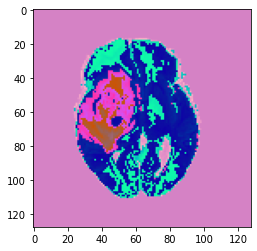

In [27]:
plt.imshow((train_x[100] * 255).astype(np.uint8))

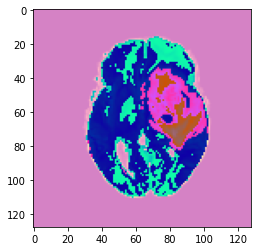

In [37]:
plt.imshow((255*data_augmentation(train_x)[100]).numpy().astype("uint8"),cmap=plt.cm.bone)

In [131]:
datagen = ImageDataGenerator(horizontal_flip=True)
df_train = pd.DataFrame({"filename":[train_x], "class":[train_y]}).astype('str')
print(df_train)

                                            filename  \
0  [[[[-0.17058824 -0.49607843 -0.23333333]\n   [...   

                                               class  
0  [[1. 0.]\n [0. 1.]\n [0. 1.]\n [1. 0.]\n [0. 1...  


In [132]:
train_generator = datagen.flow((train_x, train_y),  
                                            directory=None, 
                                              x_col="filename", y_col="class", 
                                              class_mode="categorical", 
                                              target_size=(128,128), batch_size=32)
#voir si on peux utiliser une matrice avec imagedatagenerator 

Found 0 validated image filenames belonging to 0 classes.


C:\Users\alizh\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [45]:
from keras import backend as K
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.learning_rate.assign(0.0005)
print(optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


In [46]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import datetime

NAME = "sequential2_mdl_test" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))


model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), input_shape=train_x.shape[1:]))  #64param
model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3))) #rajouter des conv pour pas diminuer la taille du réseau trop rapidement 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(32)) #Fully connected layer, needs 1D ds
model.add(Dropout(0.2)) #freeze 20% des poids
model.add(Activation('relu'))

model.add(Dense(2)) #mieux de faire sortir 2 classes 
model.add(Activation('softmax')) #activation=fct non lineaire, pb sigmoid=grad tres faible pr petites val -> mieux d'utiliser relu (grad 0 ou 1, pas de vanishing grad)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_10 (Activation)   (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 59, 59, 16)      

In [ ]:
# model.fit(train_x ,train_y, batch_size=6, epochs=30, validation_split=0.2,callbacks=[tensorboard])

# New approach using an other type of imaging => T1W
Hypothesis : there is not particular characteristic regarding the methylation that's why we get random results

## Dataset preparation

In [2]:
#create output dataset folders
os.makedirs('./T1w_train', exist_ok = True)
print('T1w train folder created')

T1w train folder created


348642 total files
77627 T1w files
585 middle slices
Display first image:
00000/T1w/Image-16.dcm


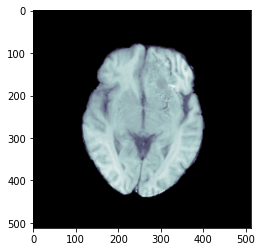

the end
the end


KeyboardInterrupt: 

In [12]:
filepath =  'E:\\Proj_data/train.zip'
with zipfile.ZipFile(filepath, 'r') as zfile:
    # Liste de tous les fichiers dans le ZIP
    all_files = zfile.namelist()
    print(len(all_files),"total files")
    
    # Filtrer pour ne garder que les chemins qui contiennent "FLAIR"
    T1w_files1 = [f for f in all_files if 'T1w' in f] #creer liste avec tout les fichiers flair
    T1w_files = [f for f in T1w_files1 if not 'CE' in f]
    print(len(T1w_files),"T1w files")
    
    # Construire dict avec les IDs d'image existant & tous les slices pour chaque image
    T1w_per_image = {}
    for f in T1w_files:
        #print(f)
        image_id = f.split('/')[0] #nom des dossier ex. 00000
        #print(image_id)
        slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) #numero de l'image ex Image-50 --> 50
        #print(slice_id)
        if image_id not in T1w_per_image: #ajouter l'image dans le dossier 
            T1w_per_image[image_id] = []
        T1w_per_image[image_id].append(slice_id)
        
    #print(T1w_per_image)
    
    # Trouver le slice du milieu pour chaque image
    T1w_middle_slices = []
    for image_id in T1w_per_image:
        T1w_per_image[image_id].sort()
        middle_slice = T1w_per_image[image_id][len(T1w_per_image[image_id])//2]
        T1w_middle_slices.append('%s/T1w/Image-%d.dcm'%(image_id, middle_slice-1))
    
    print(len(T1w_middle_slices),"middle slices") 
    
    # Afficher le 1er
    print("Display first image:")
    for f in T1w_middle_slices:
        try:
            print(f)
            data = zfile.open(f)
            ds = dicom.dcmread(data)
            plt.figure()
            plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
            plt.show()
        except :
            continue
        break
        
    for i in range(len(T1w_middle_slices)) :
        if (T1w_middle_slices==[]) :
            print('Empty list')
            break
        else :
            for f in T1w_middle_slices:  #reussir a sortir chaque filepath de la list 
                try :
                    data = zfile.open(f)
                except KeyError :
                    print("error, file doesnt exist -> skip")
                    print(f)
                    continue 
                    
                #print(data)
                ds = dicom.dcmread(data)
                image_id = f.split('/')[0] #nom des dossier ex. 00000
                slice_id = int(f.rsplit('/')[-1].split('-')[-1].split('.')[0]) 
                image_path = './T1w_train/' + str(image_id) + '_T1w_Image-' + str(slice_id) + '.dcm'   #'./train/00071_T1wCE_Image-51.dcm' -> fonctionne avec ca  #pas avec l'autre pcq dossier 000000 n'E pas dans le file train
                #print(image_path)
                #print(ds.pixel_array)
                #print(type(ds.pixel_array))
 
                image_path = image_path.replace('.dcm', '.png') #convertir type d'image de dcm en png
                #print(image_path)
                
                
                plt.imsave(image_path ,ds.pixel_array) 
                
                if (image_id==str(1010).zfill(5)):
                    print("the end")
                    break
    print("done")
    

In [15]:
#load the dataset created 
path = './T1w_train'
for im in os.listdir(path) :
    im_array = cv2.imread(os.path.join(path,im))
    #plt.imshow(im_array,cmap=plt.cm.bone)
    #plt.show()

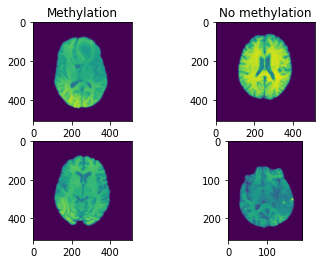

In [65]:
#display some images
im1 = imread('./T1w_train/00006_T1w_Image-16.png')
im2 = imread('./T1w_train/00009_T1w_Image-16.png')
im3 = imread('./T1w_train/00066_T1w_Image-14.png')
im4 = imread('./T1w_train/00172_T1w_Image-96.png')

plt.subplot(221)
plt.imshow(im1, cmap=plt.cm.bone)  # set the color map to bone
plt.title('Methylation')

plt.subplot(222)
plt.imshow(im2, cmap=plt.cm.bone)  # set the color map to bone
plt.title('No methylation')

plt.subplot(223)
plt.imshow(im3, cmap=plt.cm.bone)  # set the color map to bone

plt.subplot(224)
plt.imshow(im4, cmap=plt.cm.bone)  # set the color map to bone


In [66]:
print(im_array.shape)

(256, 192, 3)


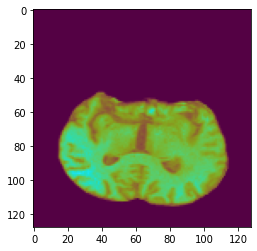

In [67]:
#resizing the data
IM_SIZE = 128
new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
plt.imshow(new_array)
plt.show()

In [68]:
import csv 
image_labels = {}
with open('E:\\Proj_data/train_labels.csv', mode='r') as fp:
    reader = csv.reader(fp)
    header = True
    for label,value in reader:
        if header:
            header = False
            continue # skip first line
        image_labels[label] = value
print(image_labels)
#image_labels['00002'] devrait te donner '1', etc.

{'00000': '1', '00002': '1', '00003': '0', '00005': '1', '00006': '1', '00008': '1', '00009': '0', '00011': '1', '00012': '1', '00014': '1', '00017': '0', '00018': '0', '00019': '0', '00020': '1', '00021': '0', '00022': '0', '00024': '0', '00025': '1', '00026': '1', '00028': '1', '00030': '0', '00031': '1', '00032': '0', '00033': '1', '00035': '1', '00036': '0', '00043': '1', '00044': '0', '00045': '0', '00046': '1', '00048': '1', '00049': '0', '00052': '1', '00053': '0', '00054': '1', '00056': '1', '00058': '1', '00059': '1', '00060': '1', '00061': '0', '00062': '1', '00063': '1', '00064': '0', '00066': '1', '00068': '1', '00070': '1', '00071': '1', '00072': '0', '00074': '1', '00077': '1', '00078': '1', '00081': '0', '00084': '0', '00085': '1', '00087': '1', '00088': '0', '00089': '1', '00090': '0', '00094': '1', '00095': '0', '00096': '1', '00097': '0', '00098': '1', '00099': '0', '00100': '1', '00102': '0', '00104': '0', '00105': '1', '00106': '1', '00107': '1', '00108': '0', '0010

In [69]:
#creating the training dataset 
#original code from https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

T1w_train_data = []

def create_train_ds():
    #length = len(image_labels)
    #print(length)
    for im in os.listdir(path) :            
        k = im.split('_')[0]
        try :
            im_array = cv2.imread(os.path.join(path,im))
            new_array = cv2.resize(im_array, (IM_SIZE, IM_SIZE))
            print(k)
            print(image_labels[k])
            T1w_train_data.append([new_array,image_labels[k]])
        except : 
            print('error')
            print(im)
            continue


        
create_train_ds()
#print(new_array)
print(len(new_array))

error
.ipynb_checkpoints
00000
1
00002
1
00003
0
00005
1
00006
1
00008
1
00009
0
00011
1
00012
1
00014
1
00017
0
00018
0
00019
0
00020
1
00021
0
00022
0
00024
0
00025
1
00026
1
00028
1
00030
0
00031
1
00032
0
00033
1
00035
1
00036
0
00043
1
00044
0
00045
0
error
00046_T1w_Image-15.png
00048
1
00049
0
00052
1
00053
0
00054
1
00056
1
00058
1
00059
1
00060
1
00061
0
00062
1
00063
1
00064
0
00066
1
00068
1
00070
1
00071
1
00072
0
00074
1
00077
1
00078
1
00081
0
00084
0
00085
1
00087
1
00088
0
00089
1
00090
0
00094
1
00095
0
00096
1
00097
0
00098
1
00099
0
00100
1
00102
0
00104
0
00105
1
00106
1
00107
1
00108
0
00109
1
00110
0
00111
0
00112
0
00113
0
00116
0
00117
1
00120
1
00121
0
00122
0
00123
0
00124
0
00128
1
00130
0
00132
0
00133
0
00134
1
00136
1
00137
0
00138
1
00139
1
00140
1
00142
0
00143
1
00144
1
00146
1
00147
0
00148
0
00149
0
00150
0
00151
0
00154
0
00155
1
00156
1
00157
0
00158
0
00159
1
00160
1
00162
0
00165
0
00166
1
00167
0
00169
0
00170
0
00171
1
00172
0
00176
0
00177
1
00

In [70]:
print(len(T1w_train_data))

584


In [71]:
T1w_train_x = [] #feature set
T1w_train_y = [] #labels

for features,label in T1w_train_data:
    T1w_train_x.append(features)
    T1w_train_y.append(label)

print(T1w_train_x[0].reshape(-3, IM_SIZE, IM_SIZE, 3))  #3 for RGB, 1 for grayscale 
#print(label['value'])
T1w_train_x = np.array(T1w_train_x).reshape(-3, IM_SIZE, IM_SIZE, 3)

[[[[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  ...

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]

  [[84  1 68]
   [84  1 68]
   [84  1 68]
   ...
   [84  1 68]
   [84  1 68]
   [84  1 68]]]]


In [72]:
#save the data
#code from https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

pickle_out = open("T1w_train_x.pickle","wb")
pickle.dump(T1w_train_x, pickle_out)
pickle_out.close()

pickle_out = open("T1w_train_y.pickle","wb")
pickle.dump(T1w_train_y, pickle_out)
pickle_out.close()


## Training with the same model as with FLAIR images

In [20]:
#Data prep, loading the dataset 

import datetime

NAME = "T1w_mdl_test" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

pickle_in = open("T1w_train_x.pickle","rb")
T1w_train_x = pickle.load(pickle_in)

pickle_in = open("T1w_train_y.pickle","rb")
T1w_train_y = pickle.load(pickle_in)

T1w_train_x = T1w_train_x/255.0-0.5
print(len(T1w_train_x))

T1w_train_y_1D = T1w_train_y
T1w_train_y = np.asarray(T1w_train_y).astype('float32').reshape((-1,1))

T1w_train_y = tf.keras.utils.to_categorical(T1w_train_y)
print(len(T1w_train_y))

584
584


In [21]:
T1w_train_xx, T1w_test_x, T1w_train_yy_1D, T1w_test_y_1D = train_test_split(T1w_train_x, T1w_train_y_1D, test_size=0.1)

#keeping 1D array of test label to use it for the confusion matrix 
T1w_train_yy = np.asarray(T1w_train_yy_1D).astype('float32').reshape((-1,1))
T1w_train_yy = tf.keras.utils.to_categorical(T1w_train_yy)
T1w_test_y = np.asarray(T1w_test_y_1D).astype('float32').reshape((-1,1))
T1w_test_y = tf.keras.utils.to_categorical(T1w_test_y)
print(T1w_test_y_1D)
print(T1w_test_y)

T1w_train_X, T1w_val_X, T1w_train_Y, T1w_val_Y = train_test_split(T1w_train_xx, T1w_train_yy, test_size=0.15) #split un test dataset de ici aussi, par defaut c'est shuffled 

['0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0']
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [22]:
from keras import backend as K
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.learning_rate.assign(0.0001)
print(optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [23]:
#Model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=T1w_train_X.shape[1:]))  #64param
model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3))) #rajouter des conv pour pas diminuer la taille du réseau trop rapidement 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(32)) #Fully connected layer, needs 1D ds
model.add(Dropout(0.2)) #freeze 20% des poids
model.add(Activation('relu'))

model.add(Dense(2)) #mieux de faire sortir 2 classes 
model.add(Activation('softmax')) #activation=fct non lineaire, pb sigmoid=grad tres faible pr petites val -> mieux d'utiliser relu (grad 0 ou 1, pas de vanishing grad)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_10 (Activation)   (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 59, 59, 16)        4624      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 57, 16)       

In [24]:
model.fit(T1w_train_X ,T1w_train_Y, batch_size=6, epochs=30, validation_data = (T1w_val_X, T1w_val_Y) ,callbacks=[tensorboard])

Epoch 1/30
75/75 [==============================] - 14s 172ms/step - loss: 0.6956 - categorical_accuracy: 0.4641 - val_loss: 0.6929 - val_categorical_accuracy: 0.5190
Epoch 2/30
75/75 [==============================] - 11s 144ms/step - loss: 0.6920 - categorical_accuracy: 0.5112 - val_loss: 0.6893 - val_categorical_accuracy: 0.5063
Epoch 3/30
75/75 [==============================] - 11s 142ms/step - loss: 0.6885 - categorical_accuracy: 0.5381 - val_loss: 0.6866 - val_categorical_accuracy: 0.6456
Epoch 4/30
75/75 [==============================] - 9s 124ms/step - loss: 0.6849 - categorical_accuracy: 0.5628 - val_loss: 0.6823 - val_categorical_accuracy: 0.5316
Epoch 5/30
75/75 [==============================] - 8s 113ms/step - loss: 0.6765 - categorical_accuracy: 0.5650 - val_loss: 0.6795 - val_categorical_accuracy: 0.5570
Epoch 6/30
75/75 [==============================] - 9s 122ms/step - loss: 0.6681 - categorical_accuracy: 0.5740 - val_loss: 0.6760 - val_categorical_accuracy: 0.5443
E

In [25]:
model.evaluate(T1w_test_x,T1w_test_y, batch_size=6)

10/10 [==============================] - 0s 21ms/step - loss: 1.2814 - categorical_accuracy: 0.6102


[1.2813501358032227, 0.6101694703102112]

## Confusion matrix

In [26]:
#use the test dataset
T1w_Y_pred = model.predict(T1w_test_x)
T1w_y_pred = np.argmax(T1w_Y_pred, axis=1)

print(T1w_y_pred.shape)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(T1w_test_y_1D, T1w_y_pred.astype(str), target_names=target_names))
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

(59,)
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        25
           1       0.64      0.74      0.68        34

    accuracy                           0.61        59
   macro avg       0.60      0.59      0.59        59
weighted avg       0.60      0.61      0.60        59



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Normalized confusion matrix


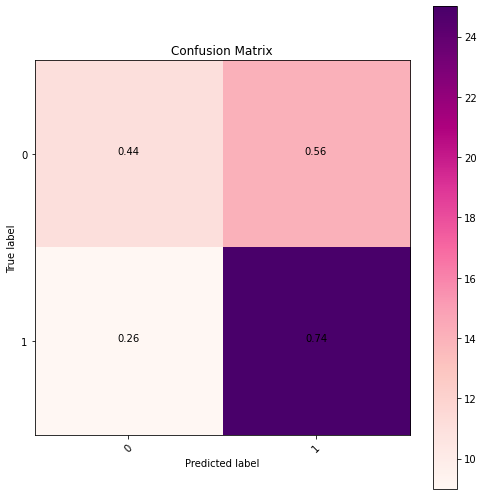

In [27]:
#Confusion Matrix 
cm = confusion_matrix(T1w_test_y_1D,T1w_y_pred.astype(str))
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

As we saw with FLAIR type image, we get random result 